# Fluorescence decay objective function

The first step for determining a set optimal of model parameters for a data set is to define an objective function. An objective function attempts to maximize profits or minimize losses based on the data and the parameter of the model. Here, it is illustrated how different parts of `IMP.bff` can be combined to yield (i) a forward model and an (ii) objective function for the data and the model. The computation of a forward model that considers multiple experimental nuisances is described [elsewhere](decay_forward_model.ipynb). Here, an objective function is defined that can be used as a template for modeling.

First, the Python modules and the data are loaded.

In [1]:
import IMP
import IMP.bff

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [2]:
dt = 0.0141 # time resolution (bin width of decay histogram)

fns = {
    "lintable": IMP.bff.get_example_path("spectroscopy/hgbp1/eTCSPC_whitelight.txt"),
    "irf": IMP.bff.get_example_path("spectroscopy/hgbp1/eTCSPC_Prompt.txt"),
    "donor": IMP.bff.get_example_path("spectroscopy/hgbp1/eTCSPC_Donor.txt"),
    "fret": IMP.bff.get_example_path("spectroscopy/hgbp1/eTCSPC_FRET.txt")
}

data = dict()
for key in fns:
    df = pd.read_csv(fns[key], skiprows=6, sep='\t')
    data[key] = IMP.bff.DecayCurve(x=df['Chan'] * dt, y=df['Data'])

Here, we define an generic mode for the human guanalylate binding protein 1 (hGBP1) that describes the experimental data by a set of fluorescence lifetimes. The model considers the instrument response function (IRF), differential non linearities (DNL), and non-fluorescent background. 

In [3]:
class objective(object):
    
    def __init__(
        self, 
        data: IMP.bff.DecayCurve,
        irf: IMP.bff.DecayCurve,
        linearization_table: IMP.bff.DecayCurve,
        lifetime_settings: dict,
        convolution_settings: dict,
        pile_up_settings: dict,
        background_settings: dict,
        dnl_settings: dict,
        scale_settings: dict,
        score_settings: dict
    ):
        self.data = data
        self.model = IMP.bff.DecayCurve(x=data.x)
        self.lifetime_handler = IMP.bff.DecayLifetimeHandler(**lifetime_settings)
        self.convolve = IMP.bff.DecayConvolution(
            lifetime_handler=self.lifetime_handler,
            **convolution_settings
        )
        self.pile_up = IMP.bff.DecayPileup(data, **pile_up_settings)
        self.bg = IMP.bff.DecayPattern(**background_settings)
        self.dnl = IMP.bff.DecayLinearization(linearization_table, **dnl_settings)
        self.scale = IMP.bff.DecayScale(data, **scale_settings)
        self.score = IMP.bff.DecayScore(self.model, data, **score_settings)

    def __call__(self, *args, **kwargs):
        self.convolve.add(self.model)
        self.pile_up.add(self.model)
        self.bg.add(self.model)
        self.dnl.add(self.model)
        self.scale.add(self.model)
        self.score.set_model(self.model)
        return self.score.score


Here, the parameters of the model (that are not optimized) are part of a dictionary that is passed to the objective function. 

In [4]:
settings = {
    "dnl_settings": {
        "start": 0, "stop": -1,
        "n_window": 20
    },
    "background_settings": {
        "start": 0, "stop": -1,
        "constant_offset": 2.,
        "pattern": None,
        "pattern_fraction": 0.0,
        "active": True
    },
    "pile_up_settings": {
        "active": False
    },
    "convolution_settings": {
        "start": 100, "stop": 3800,
        "instrument_response_function": data["irf"],
        "convolution_method": IMP.bff.DecayConvolution.FAST,
        "excitation_period": 100,
        "irf_shift_channels": 0.0,
        "irf_background_counts": 0.0,
    },
    "lifetime_settings": {
        'lifetime_spectrum': [0.8, 4.0, 0.2, 2.0],
        'abs_lifetime_spectrum': False,   # True -> take abs of liftime spectrum
        'use_amplitude_threshold': False, # True -> discriminate lifetimes below threshold
        'amplitude_threshold': 0.0
    },
    "scale_settings": {
        "start": 0, "stop": -1,
        "constant_background": 0.0,
        "active": True,
        "blank_outside": True
    },
    "score_settings": {
        "score_type": "poisson",
        "start": 0, "stop": -1    
    }
}

The objective function computes a model and returns a score. The score can be used to optimize parameters.

In [5]:
ob = objective(
    data["donor"],
    data["irf"],
    data["lintable"],
    **settings
)
ob()

232978.91261433408

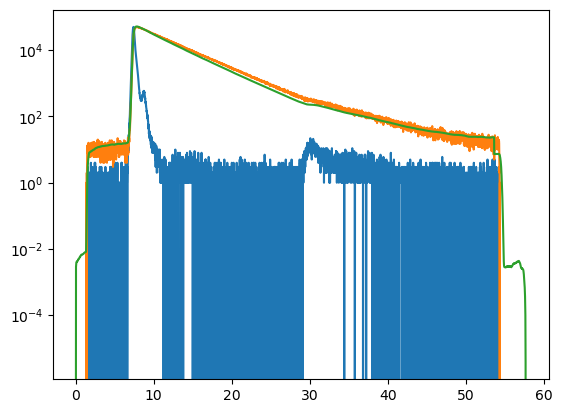

In [7]:
plt.semilogy(ob.convolve.irf.x, ob.convolve.irf.y)
plt.semilogy(ob.data.x, ob.data.y)
plt.semilogy(ob.model.x, ob.model.y)
plt.show()